# Vaccinations data analysis

In [81]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import ticker as mticker
from matplotlib.patches import Patch

from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns

from scseirx import analysis_functions as af
import data_creation_functions as dcf

## Prepare the data

In [82]:
stype_names = {'primary':'primary', 'primary_dc':'primary\nwith daycare',
               'lower_secondary':'lower secondary',
               'lower_secondary_dc':'lower secondary\nwith daycare',
               'upper_secondary':'upper secondary', 'secondary':'secondary'}

school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']

school_types = school_types

In [83]:
src_path = '../../data/vaccinations_omicron/simulation_results'
res_path = '../../plots/vaccinations_omicron'

In [84]:
from importlib import reload
reload(dcf)

<module 'data_creation_functions' from '/home/jana/Projects/COVID_schools/analysis/code/vaccinations_omicron/data_creation_functions.py'>

In [85]:
for stype in school_types:
    print(stype)
    data = dcf.get_data(stype, src_path)
    data["student_screening_interval"] = data["student_screening_interval"]\
        .replace({"3":3, "7":7})
    data["teacher_screening_interval"] = data["teacher_screening_interval"]\
        .replace({"3":3, "7":7})
    data['measure'] = np.nan
    dcf.set_individual_measures(data)
    dcf.set_measure_packages(data)
    data.to_csv(join(src_path, '{}_combined_ensembles.csv'.format(stype)), index=False)

primary
primary_dc
lower_secondary
lower_secondary_dc
upper_secondary
secondary


In [86]:
N_runs = 5000

school_types.reverse()
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'vaccinations.csv'))

params_packages = [(N_runs, st, 
           row['index_case'],
           'same_day_antigen',
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['half_classes'],
           row['ventilation_modification'],
           row['teacher_vaccination_ratio'],
           row['student_vaccination_ratio']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

In [87]:
turnovers = {'same':0, 'one':1, 'two':2, 'three':3}
bmap = {True:'T', False:'F'}

params = params_packages

for stype in school_types:
    print(stype)
    spath_ensmbl = join(src_path,'{}'.format(stype))
    
    observables = pd.DataFrame()
    for N_runs, pstype, index_case, ttype, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, half_classes, ventilation_mod, \
        t_vacc_ratio, s_vacc_ratio in params:
        
        if pstype != stype:
            continue
            
        turnover, _, test = ttype.split('_')
        turnover = turnovers[turnover]
        
        measure_string = '{}_test-{}_turnover-{}_index-{}_tf-{}_sf-{}_tmask-{}'\
        .format(stype, test, turnover, index_case[0], t_screen_interval,
                s_screen_interval, bmap[teacher_mask]) +\
                '_smask-{}_half-{}_vent-{}_tvacc-{}_svacc-{}'\
        .format(bmap[student_mask], bmap[half_classes], ventilation_mod,
                t_vacc_ratio, s_vacc_ratio)
        
        ensmbl = pd.read_csv(join(spath_ensmbl, measure_string + '.csv'))
        ensmbl = ensmbl.drop(columns=['Unnamed: 0'])
        
        row = {'test_type':test,
               'turnover':turnover,
               'index_case':index_case,
               'student_screen_interval':s_screen_interval,
               'teacher_screen_interval':t_screen_interval,
               'student_mask':student_mask,
               'teacher_mask':teacher_mask,
               'half_classes':half_classes,
               'ventilation_modification':ventilation_mod,
               'teacher_vaccination_ratio':t_vacc_ratio,
               'student_vaccination_ratio':s_vacc_ratio}
        
        N = len(ensmbl)
        ensmbl = ensmbl[ensmbl['infected_agents'] > 0]
        N_red = len(ensmbl)
        row.update({'no_outbreak':(N - N_red) / N})
        for col in ensmbl.columns:
            row.update(af.get_statistics(ensmbl, col))
        observables = observables.append(row, ignore_index=True)

    # calculate the number of tests per day and agent in the school
    observables['N_tests_per_day_per_agent'] = \
    (observables['N_diagnostic_tests_median'] + observables['N_preventive_tests_median']) /\
    observables['duration_median'] / observables['N_school_agents_median']
    
    screen_cols = ['test_type', 'turnover', 'index_case', 'student_screen_interval',
            'teacher_screen_interval', 'student_mask', 'teacher_mask',
            'half_classes', 'ventilation_modification', 'student_vaccination_ratio',
            'teacher_vaccination_ratio']

    other_cols = [c for c in observables.columns if c not in screen_cols]
    observables = observables[screen_cols + other_cols]
    
    for col in ['infected_teachers_median', 'infected_students_median', 
                        'infected_family_members_median',
                        'infected_teachers_0.90', 'infected_students_0.90', 
                        'infected_family_members_0.90']:
        observables[col] = observables[col].round(0).astype(int)
    
    observables.to_csv(join(src_path, '{}_observables'.format(stype) + '.csv'))

secondary
upper_secondary
lower_secondary_dc
lower_secondary
primary_dc
primary


## Violin plot

In [88]:
def annotate(ax, data, order, offset):
    for i, measure in enumerate(order):
        scenario_student = data[(data['measure'] == measure) &\
                                (data['index_case'] == 'student')]
        scenario_teacher = data[(data['measure'] == measure) &\
                                (data['index_case'] == 'teacher')]
        
        avg_R_student = scenario_student['R0'].mean()
        avg_R_teacher = scenario_teacher['R0'].mean()
        
        ax.text(3.2 + offset, i - 0.15, '${:1.1f}$'\
                .format(avg_R_teacher), fontsize=8)
        ax.text(3.2 + offset, i + 0.2, '${:1.1f}$'\
                .format(avg_R_student), fontsize=8)

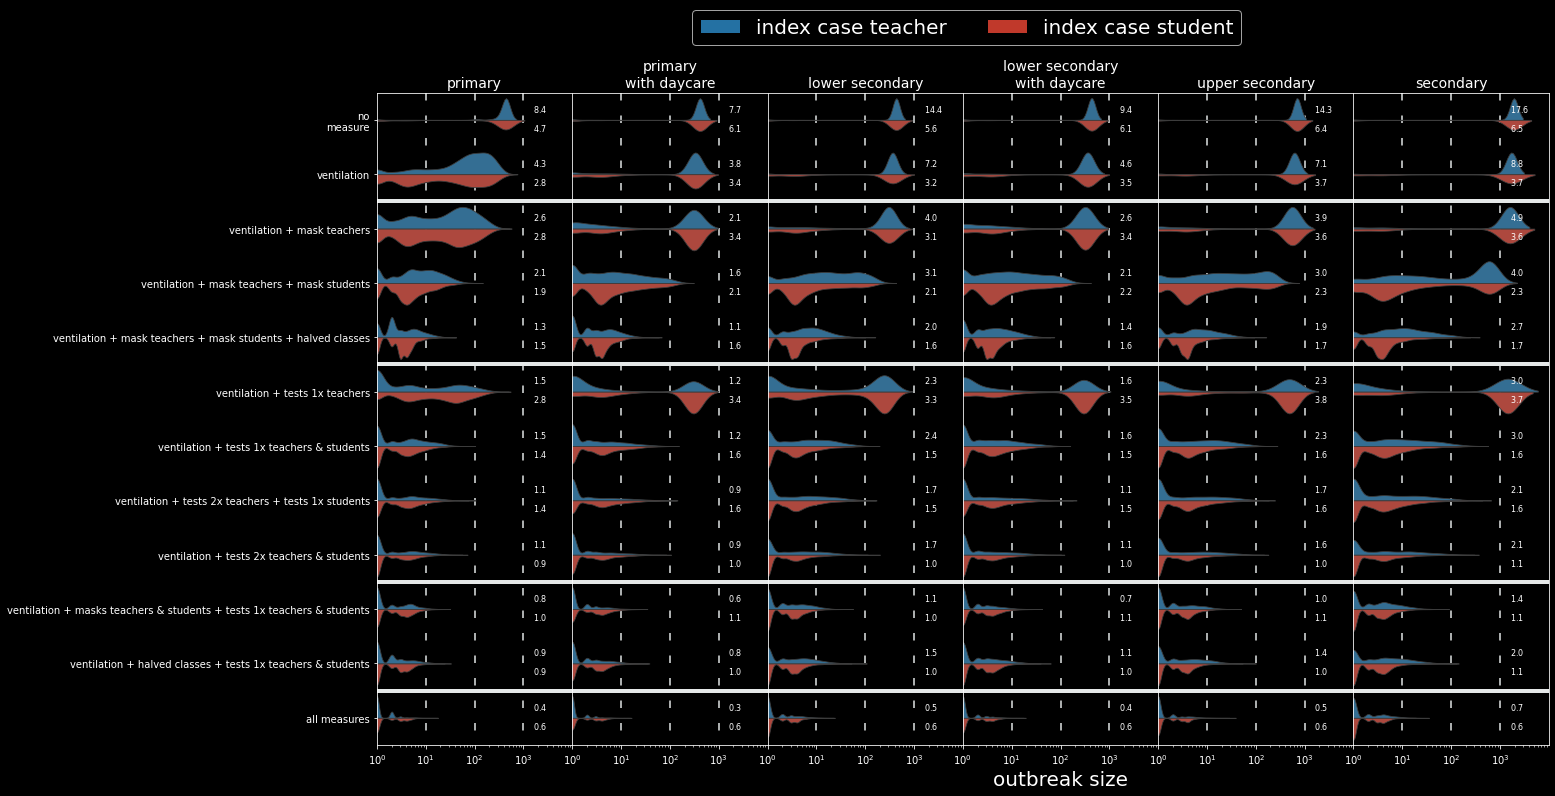

In [89]:
fig, axes = plt.subplots(figsize=(21, 12))
gs1 = gridspec.GridSpec(1, 6)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 
axes =  [plt.subplot(gs1[i]) for i in range(6)]

order = ['no\nmeasure', 
         'ventilation',
         'ventilation + mask teachers',
         'ventilation + mask teachers + mask students',
         'ventilation + mask teachers + mask students + halved classes',
         'ventilation + tests 1x teachers',
         'ventilation + tests 1x teachers & students',
         'ventilation + tests 2x teachers + tests 1x students',
         'ventilation + tests 2x teachers & students',
         'ventilation + masks teachers & students + tests 1x teachers & students',
         'ventilation + halved classes + tests 1x teachers & students',
         'all measures'
        ]
#ylabels = ['no measures', '+ ventilation', '+ masks teachers', '+ masks students',
#           '+ halved classes', '+ tests teachers 1x', '+ tests students 1x',
#           '+ tests teachers 2x', '+ tests students 2x',
#           'ventilation, masks, tests 1x', 'ventilation, halved classes, tests 1x',
#           'all measures']
ylabels = order

stypes = ['primary', 'primary_dc', 'lower_secondary', 'lower_secondary_dc',
          'upper_secondary', 'secondary']


for i, stype in enumerate(stypes):
    data = pd.read_csv(join(src_path, '{}_combined_ensembles.csv'.format(stype)),
                      low_memory=False)
    data['infected_agents'] = np.log10(data['infected_agents'])
    subset = data[data["student_vaccination_ratio"] == 0.5]
    sns.violinplot(x="infected_agents", y="measure", hue="index_case",
                   data=subset, palette=['#2471A3', '#C0392B'], split=True, 
                   ax=axes[i], order=order, inner=None, linewidth=0.8, 
                   hue_order=['teacher', 'student'])
    annotate(axes[i], subset, order, 0)
    
xlims = [9999] * 6
xlims = np.log10(xlims)
for i, ax, xlim, stype in zip(range(len(axes)), axes, xlims, stypes):
    if i != 0:
        axes[i].set_yticks([])
    ax.get_legend().set_visible(False)    
    ax.set_ylabel('')
    if i != 3:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('outbreak size', fontsize=20)
    ax.set_title(stype_names[stype], fontsize=14)
    
    if i == 0:
        ax.set_yticklabels(ylabels)  

ymax = 11.5
ymin = -0.5
for ax, xlim in zip(axes, xlims):
    for ypos in [1.5, 4.5, 8.5, 10.5]:
        ax.plot([0, xlim], [ypos, ypos], color='#E5E8E8', lw=4)
    for xpos in [1, 2, 3]:
        ax.plot([xpos, xpos], [ymin, ymax],  linestyle='--', dashes=(5, 10),
            color='#E5E8E8', zorder=0)
        
    ax.set_ylim(ymax, ymin)
    ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    xticks = [np.log10(x) for p in np.arange(0, xlim) for\
                        x in np.linspace(10**p, 10**(p+1), 10)]
    ax.xaxis.set_ticks(xticks, minor=True)
    ax.set_xlim(0, xlim)

legend_ax = fig.add_axes([0.365, 0.93, 0.3, 0.05])
legend_elements = [Patch(facecolor='#2471A3', edgecolor='k',
                         label='index case teacher'),
                   Patch(facecolor='#C0392B', edgecolor='k',
                         label='index case student')]
leg = legend_ax.legend(handles=legend_elements, loc='center', ncol=2, fontsize=20)
legend_ax.set_axis_off()

#fig.tight_layout()
plt.savefig(join(res_path, 'measure_packages_omicron.pdf'), bbox_extra_artists=[leg])
plt.savefig(join(res_path, 'measure_packages_omicron.svg'), bbox_extra_artists=[leg])